## Compare Instantaneous Frequency Estimation Methods

In [15]:
import matplotlib.pyplot as plt

from submodules.CreateSyntheticEventV4 import __create_synthetic_event_v4
from submodules.MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from submodules.CreateLinearChirp import __create_linear_chirp
from submodules.Tapering import __tapering

from submodules.Modulation import __modulation
from submodules.Downsample import __downsample
from submodules.Interpolation import __interpolation
from submodules.MakeplotTraceAndPSD import __makeplot_trace_and_psd

## Configurations

In [2]:
config = {}

config['T'] = 1600
config['sps'] = 5000
config['f_lower'], config['f_upper'] = 0.01, 0.1

## Create Sysnthetic Events

##### Trace with certain frequency band

upsamling trace ....
tapering with Hanning window for 0.2 percent...
normalizing trace ...


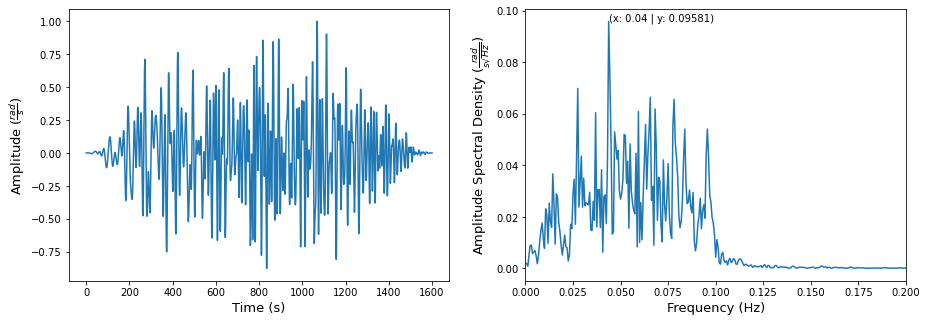

In [3]:
event, event_time =__create_synthetic_event_v4(config, 
                                               signal_type='chirp', 
                                               noise_level=None, 
                                               set_taper=True, 
                                               set_normalize=True,
                                              )


__makeplot_trace_and_spectrum(event, event_time, fmax=2*config['f_upper']);

#### Chirp signal

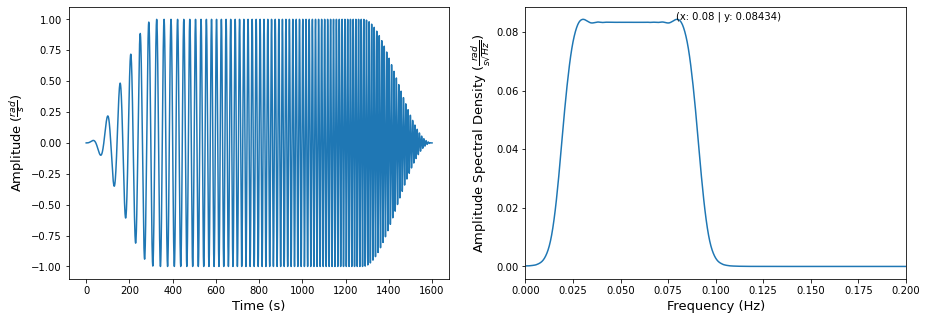

In [4]:
## generate chirp signal
chirp, timeline = __create_linear_chirp(config['T'], config['sps'], config['f_lower'], config['f_upper'])

## taper chirp to avoid Gibb's effect
chirp = __tapering(chirp, taper_type='hann', percent=0.2)

## plotting
__makeplot_trace_and_spectrum(chirp, timeline, fmax=2*config['f_upper'] );

In [17]:
modeltrace, time_modeltrace = event, event_time

# modeltrace, time_modeltrace = chirp, timeline

## Modulation

In [18]:
config['sgnc'] = 553.67
print(f"Rounded Sagnac Frequency: {round(config['sgnc'],2)} Hz")

config['modulation_index'] = 10036114.034585783
print(f"Modulation Index (scale factor): {config['modulation_index']}")

config['modulation_scheme'] = 3

## decide if oversampling is set (bool) and how much oversampling
config['oversampling'] = True
config['oversampling_factor'] = 4

Rounded Sagnac Frequency: 553.67 Hz
Modulation Index (scale factor): 10036114.034585783


In [19]:
if config['oversampling']:
    
    ## upsample using FIR filter
#     modeltrace, time_modeltrace = __upsample_FIR(modeltrace, oversampling_factor, sps)

    ## upsample using interpolation method
    modeltrace, time_modeltrace = __interpolation(modeltrace, time_modeltrace, config['T'], config['oversampling_factor']*config['sps'])
    
    ## adjust sps value
    config['sps'] *= config['oversampling_factor']

## check size of arrays
modeltrace.size, time_modeltrace.size

modeltrace is interpolated: 8000001 samples --> 32000001 samples


(32000001, 32000001)

In [20]:
synthetic_signal, timeline = __modulation(
                                          modeltrace,
                                          time_modeltrace, 
                                          config['sgnc'], 
                                          config['T'], 
                                          config['sps'], 
                                          config['modulation_index'], 
                                          config['modulation_scheme'],
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.52 sec


In [21]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='hann', percent=0.2)

In [22]:
## check array size
synthetic_signal.size, modeltrace.size

if config['oversampling']:

    sps0 = config['sps'] ## prevent overwriting
    
    ## downsample synthetic
    synthetic_signal, timeline, config['sps'] = __downsample(synthetic_signal, sps0, ds_factor=config['oversampling_factor'])
    
    ## downsample model
    modeltrace, time_modeltrace, config['sps'] = __downsample(modeltrace, sps0, ds_factor=config['oversampling_factor'])

## check array size
synthetic_signal.size, modeltrace.size

(8000001, 8000001)

-1750.55 3.35434052249e-05


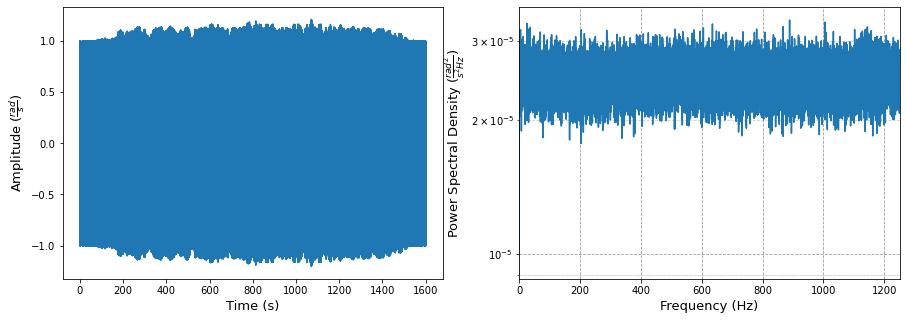

In [33]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=1/config['oversampling_factor']*config['sps']);

## Spectral Estimation

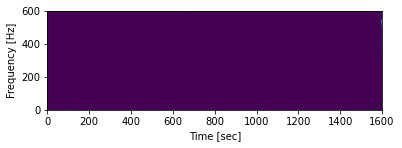

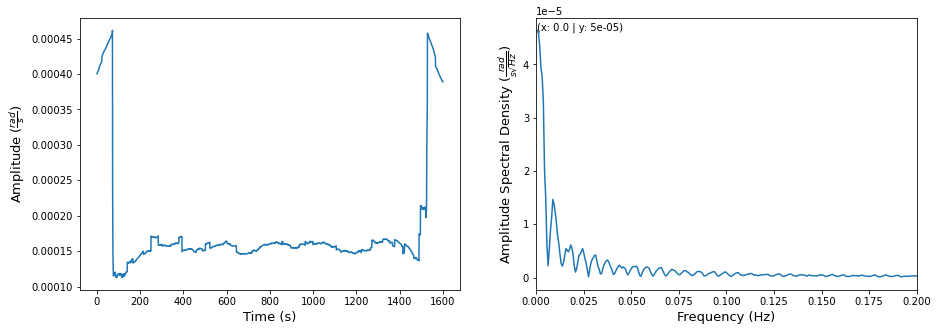

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from lspopt.lsp import spectrogram_lspopt

fs = config['sps']
T = config['T']

# x, times = chirp, timeline
# x, times = event, event_time
x, times = synthetic_signal, timeline


f, t, Sxx2 = spectrogram_lspopt(x, fs, 
                                c_parameter=20.0,
                                nperseg=4096,
                                noverlap=512,
                                nfft=None,
                                detrend='constant',
                                return_onesided=True,
                                scaling='density',
                                )

ax = plt.subplot(212)
ax.pcolormesh(t, f, Sxx2, shading='auto')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_ylim(0,600)
ax.set_xlim(0,T)

plt.show()

instaf = []
for i in range(len(Sxx2[1,:])):
    instaf.append(max(Sxx2[:,i]))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
    
instaf = moving_average(np.array(instaf), 200)

__makeplot_trace_and_spectrum(instaf, t, fmax=2*config['f_upper']);

## Testing Huang-Hilbert Transofrm 

In [26]:
import emd
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [27]:
signal = synthetic_signal
t = timeline

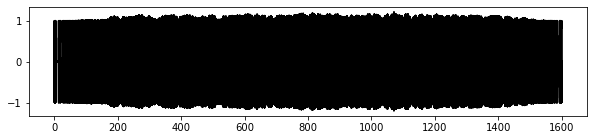

In [28]:
# Plot the first 5 seconds of data
plt.figure(figsize=(10, 2))
plt.plot(t, signal, 'k')

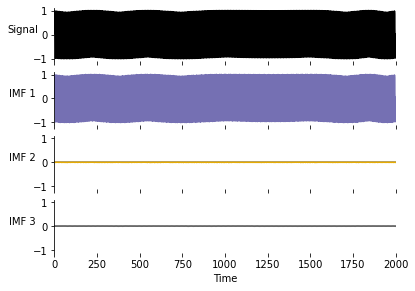

In [37]:
# Run a mask sift
imf = emd.sift.mask_sift(signal, max_imfs=3)

emd.plotting.plot_imfs(imf[:2000, :], cmap=True, scale_y=True)

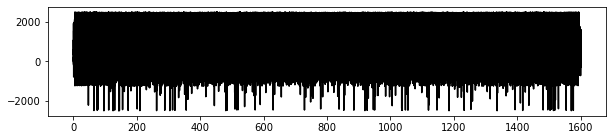

In [38]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'nht')

plt.figure(figsize=(10, 2))
plt.plot(event_time, IF, 'k')

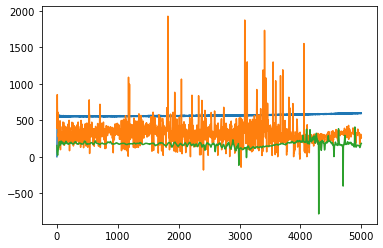

In [39]:
plt.plot(IF[:5000])

([<matplotlib.axis.XTick at 0x7f888c6d0650>], [Text(0, 0, '')])

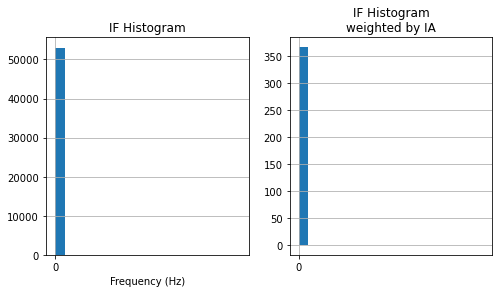

In [32]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
# Plot a simple histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, config['f_upper'], 20))
plt.grid(True)
plt.title('IF Histogram')
plt.xticks(np.arange(0, config['f_upper'], 0.2))
plt.xlabel('Frequency (Hz)')

plt.subplot(122)
# Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, config['f_upper'], 20), weights=IA[:, 2])
plt.grid(True)
plt.title('IF Histogram\nweighted by IA')
plt.xticks(np.arange(0, config['f_upper'], 0.2))